## Домашнее задание №4. GAN

### Creating config object (argparse workaround)

In [1]:
student_name = "Lyubov Antyufrieva" # Введите свое имя и фамилию

В рамках этого домашнего задания мы разберем архитектуру простейшего GAN для генерации картинок одежды и попробуем ее немного модифицировать

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Конфигурация
num_epochs = 20 
noise_size = 50
print_freq = 1000
batch_size = 16

# Как мы будем помечать истинные и сгенерированные изображения
real_label = 1
fake_label = 0

# Шум, из которого генератор будет делать картинки
# Заготовка - новые можно сделать с помощью .normal_()
noise = torch.FloatTensor(batch_size, noise_size)

In [4]:
# Отображает 16 картинок из pic в сетке 4x4
def show_pictures(pic):
    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(pic[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')

**Загружаем данные для работы**

In [5]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True,
                                          transform=torchvision.transforms.ToTensor(), download=True)

In [6]:
dataloader = DataLoader(train, batch_size, shuffle=True)
for batch, _ in dataloader: # Жертвуем 1 батчом из первой итерации для обучения - ничего страшного
    break

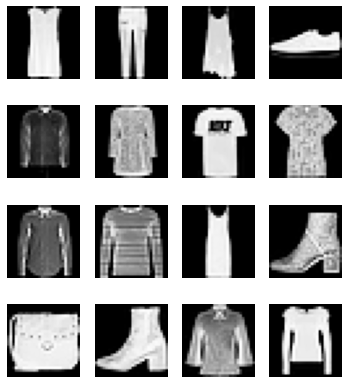

In [7]:
show_pictures(batch.reshape(-1, 28, 28))

**Реализация GAN**

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

In [10]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [11]:
def train(generator, discriminator, criterion):
    ERRD_x = np.zeros(num_epochs)
    ERRD_z = np.zeros(num_epochs)
    ERRG = np.zeros(num_epochs)
    N = len(dataloader)

    for epoch in range(num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            """
            Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            """
            discriminator.zero_grad()
            label = torch.FloatTensor(batch_size) # место для меток

            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output.view(label.shape), label)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()

            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output.view(label.shape), label)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()
        
            optim_D.step()
        
            """
            Generator stage: maximize log(D(G(x))
            """
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output.view(label.shape), label)
            ERRG[epoch] += errG.item()
            errG.backward()
        
            optim_G.step()
        
            if (iteration+1) % print_freq == 0:
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
    return ERRG, ERRD_x, ERRD_z
ERRG, ERRD_x, ERRD_z = train(generator, discriminator, criterion)

Epoch:1 Iter: 1000 errD_x: 0.21 errD_z: 0.24 errG: 1.93
Epoch:1 Iter: 2000 errD_x: 0.49 errD_z: 0.24 errG: 2.06
Epoch:1 Iter: 3000 errD_x: 0.01 errD_z: 0.32 errG: 2.76
Epoch:2 Iter: 1000 errD_x: 0.01 errD_z: 0.02 errG: 3.70
Epoch:2 Iter: 2000 errD_x: 0.23 errD_z: 0.09 errG: 2.53
Epoch:2 Iter: 3000 errD_x: 0.19 errD_z: 0.06 errG: 3.56
Epoch:3 Iter: 1000 errD_x: 0.07 errD_z: 0.07 errG: 3.54
Epoch:3 Iter: 2000 errD_x: 0.01 errD_z: 0.10 errG: 2.48
Epoch:3 Iter: 3000 errD_x: 0.06 errD_z: 0.10 errG: 2.58
Epoch:4 Iter: 1000 errD_x: 0.03 errD_z: 0.17 errG: 3.62
Epoch:4 Iter: 2000 errD_x: 0.29 errD_z: 0.06 errG: 4.74
Epoch:4 Iter: 3000 errD_x: 0.25 errD_z: 0.01 errG: 6.33
Epoch:5 Iter: 1000 errD_x: 0.58 errD_z: 0.09 errG: 3.21
Epoch:5 Iter: 2000 errD_x: 0.40 errD_z: 0.06 errG: 3.62
Epoch:5 Iter: 3000 errD_x: 0.21 errD_z: 0.11 errG: 3.40
Epoch:6 Iter: 1000 errD_x: 0.13 errD_z: 0.18 errG: 2.86
Epoch:6 Iter: 2000 errD_x: 0.06 errD_z: 0.23 errG: 3.20
Epoch:6 Iter: 3000 errD_x: 0.29 errD_z: 0.15 err

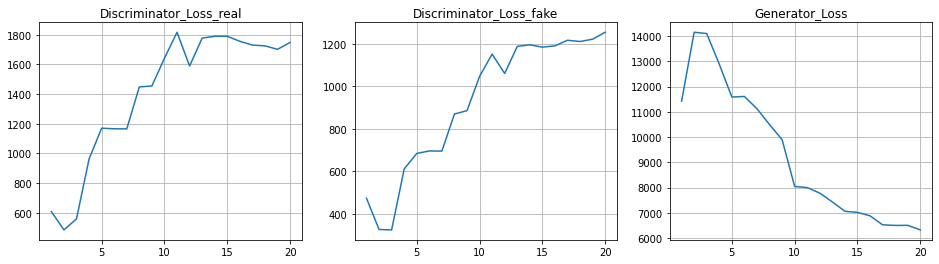

In [12]:
def show_Loss(ERRG, ERRD_x, ERRD_z):
    fig=plt.figure(figsize=(16, 4))
    p1 = plt.subplot(1, 3, 1)
    p2 = plt.subplot(1, 3, 2)
    p3 = plt.subplot(1, 3, 3)
    
    p1.plot(range(1,num_epochs+1), ERRD_x)
    p1.grid(True)
    p1.set_title('Discriminator_Loss_real')
    
    p2.plot(range(1,num_epochs+1), ERRD_z)
    p2.grid(True)
    p2.set_title('Discriminator_Loss_fake')
                 
    p3.plot(range(1,num_epochs+1), ERRG)
    p3.grid(True)
    p3.set_title('Generator_Loss')
show_Loss(ERRG, ERRD_x, ERRD_z)

torch.Size([16, 784])


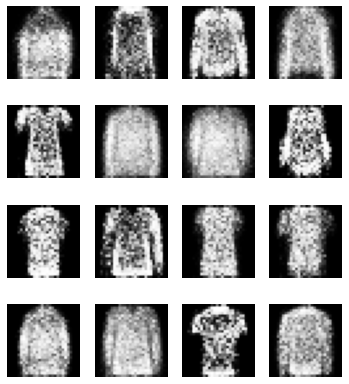

In [13]:
# Смотрим на результат
noise.data.normal_(0, 1)
fake = generator(noise)
print(fake.shape)

show_pictures(fake)

### Задание

1) Посмотрите на реализацию GAN выше. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками.  
  (Опционально) Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте реализацию, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.  
Спасибо за выполнение заданий!

torch.Size([16, 784])


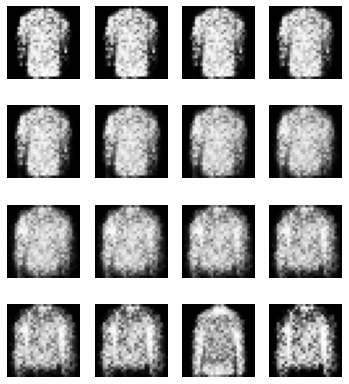

In [14]:
# Генерим шум делаем интерполяцию между [0] и [15]
noise.data.normal_(0, 1) 
delta = noise[15] - noise[0]

for i in range (1, 14):
    noise[i] = noise[0] + i*delta/15
    
fake = generator(noise)
print(fake.shape)

show_pictures(fake)

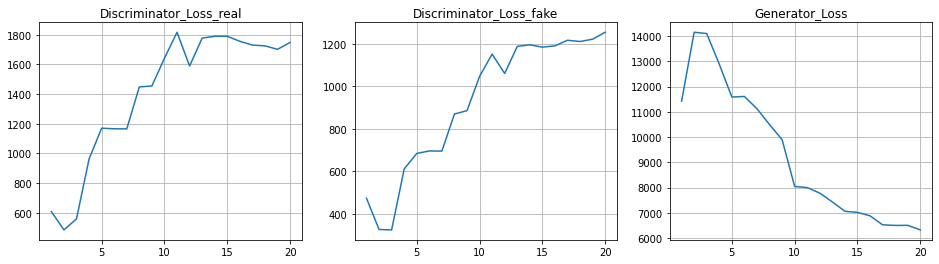

In [15]:
show_Loss(ERRG, ERRD_x, ERRD_z)